<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Package and Data Import</h2>
</div>

In [1]:
# Import relevant packages
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint

In [2]:
# Import dataset
df = pd.read_csv("https://drive.google.com/uc?export=download&id=1zIn4Ltwkjc-aJT5mXMjZZDZR0ilNX3TV")
df.head()

,Unnamed: 0,Mutant1,Mutant2,Mutant3,Mutant4,Mutant5,Mutant6,Mutant7,Mutant8,Mutant9,...,WT85,WT86,WT87,WT88,WT89,WT90,WT91,WT92,WT93,WT94
0,ENSG00000000003,2723,3512,1789,3720,681,2278,2263,1562,2343,...,6470,1544,3953,2821,2169,2686,6984,1046,770,4941
1,ENSG00000000005,2,6,10,3,6,1,9,7,14,...,2,4,1,5,47,3,19,0,8,1
2,ENSG00000000419,917,819,837,1283,1114,949,1025,1755,1171,...,1901,976,1308,1169,663,1252,2047,662,1125,1233
3,ENSG00000000457,402,341,474,667,547,464,742,1002,492,...,792,485,1023,692,160,658,834,254,650,762
4,ENSG00000000460,164,79,298,182,120,129,219,222,260,...,515,88,546,197,56,477,534,73,109,378


There are no missing values in the dataset

In [3]:
# Check shape of the datset.
print(df.shape)

# Check for null values
nulls = pd.DataFrame(df.isnull().sum())
nulls.value_counts(dropna=False)

(34539, 514)


0    514
dtype: int64

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Data Preprocessing</h2>
</div>

In [4]:
# Reshape dataframe
df_t = df.T
df_t.columns = df_t.iloc[0]
df_t['samples'] = df_t.index
df_t = df_t.iloc[1:].reset_index(drop=True)

In [5]:
# Remove the numbers from the sample labels
df_t['samples'] = df_t['samples'].str.replace(r'\d+', '', regex=True)

# View changes
df_t.head()

Unnamed: 0,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288637,ENSG00000288638,ENSG00000288648,ENSG00000288657,ENSG00000288658,ENSG00000288663,ENSG00000288670,ENSG00000288674,ENSG00000288675,samples
0,2723,2,917,402,164,104,121,340,4399,829,...,1,0,46,14,15,32,569,7,55,Mutant
1,3512,6,819,341,79,256,92,1431,4642,809,...,2,0,114,0,14,16,570,4,28,Mutant
2,1789,10,837,474,298,698,242,586,3498,1190,...,3,0,7,0,16,86,626,3,44,Mutant
3,3720,3,1283,667,182,344,395,241,6019,2911,...,1,0,16,20,138,15,909,4,79,Mutant
4,681,6,1114,547,120,322,587,733,1629,1115,...,3,0,7,385,567,36,922,8,75,Mutant


In [6]:
# Check label distribution
# There is a serious class imbalance here.
df_t["samples"].value_counts(dropna=False)

Mutant    419
WT         94
Name: samples, dtype: int64

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Feature Selection</h2>
</div>

In [7]:
# Feature selection
selector = VarianceThreshold(threshold=10)
df_selected = selector.fit_transform(df_t.drop(columns="samples"))

In [8]:
# Check the extent of feature reduction
print(f"feature space reduced by {((df_selected.shape[1] - df.shape[0]) / df.shape[0]) * 100:.2f}%")

feature space reduced by -18.32%


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Random Forest Classifier</h2>
</div>

### __Train/Test Split__

In [9]:
# Split dataset into training and test subsets
X = df_selected                                                                    # Get features
y = df_t["samples"]                                                                # Get labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)               # Get training and test subets 

In [10]:
# Check label distribution in the training and test data
print(f"Label distribution in training data: \n{y_train.value_counts()}\n\n")
print(f"Label distribution in test data: \n{y_test.value_counts()}")

Label distribution in training data: 
Mutant    335
WT         75
Name: samples, dtype: int64


Label distribution in test data: 
Mutant    84
WT        19
Name: samples, dtype: int64


In [11]:


# Encode class labels Mutant: 0, WT: 1
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.fit_transform(y_test)


### __Random Forrest Training__

In [12]:
# Handle class imbalance with class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

In [13]:
# Initialize the classifier
rf = RandomForestClassifier(random_state=42, class_weight=class_weights_dict, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200)

In [14]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf.fit(X_train_scaled, y_train_enc)

RandomForestClassifier(class_weight={0: 0.6121718377088305,
                                     1: 2.728723404255319},
                       max_depth=10, min_samples_leaf=2, n_estimators=200,
                       random_state=42)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Model Evaluation</h2>
</div>

### __Accuracy Score and Classification Report__

In [15]:
# Predictions on test set
y_pred = rf.predict(X_test_scaled)

In [16]:
# Accuracy score
accuracy = accuracy_score(y_test_enc, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9806


In [17]:
# Classification report
print("Classification Report:\n", classification_report(y_test_enc, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.89      0.94        19

    accuracy                           0.98       103
   macro avg       0.99      0.95      0.97       103
weighted avg       0.98      0.98      0.98       103



### __Confusion Matrix__

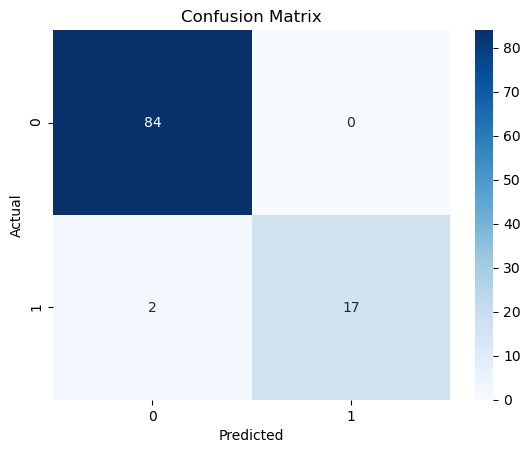

In [18]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_enc, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### __Feature Importance__

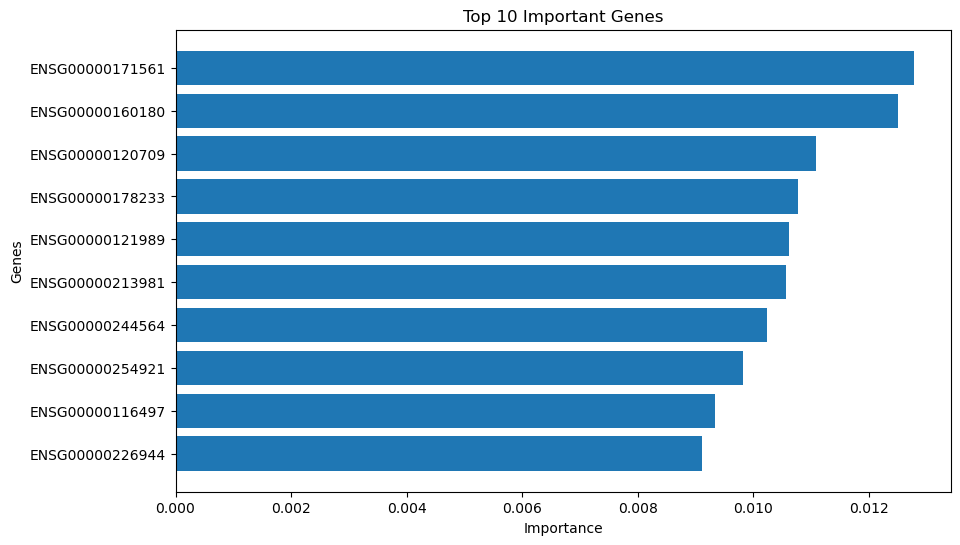

In [19]:
# Feature Importance
feature_importances = rf.feature_importances_
top_features_idx = np.argsort(feature_importances)[-10:]  # Top 10 most important features

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features_idx)), feature_importances[top_features_idx], align='center')
plt.yticks(range(len(top_features_idx)), df_t.columns[top_features_idx])
plt.title('Top 10 Important Genes')
plt.xlabel('Importance')
plt.ylabel('Genes')
plt.show()

### __ROC Curve__

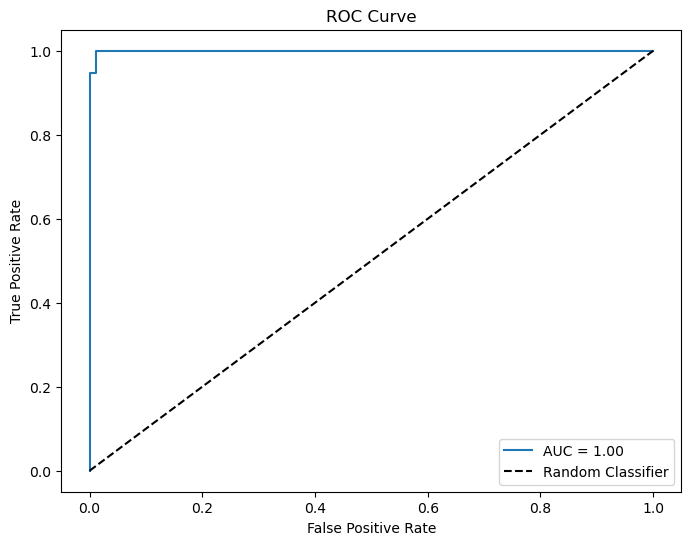

In [20]:
# ROC Curve and AUC
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_enc, y_pred_proba)
roc_auc = roc_auc_score(y_test_enc, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### __Precision-Recall Curve__

Considering the class imbalance in the trainng and test data, a precision-recall curve might be more interpretable.

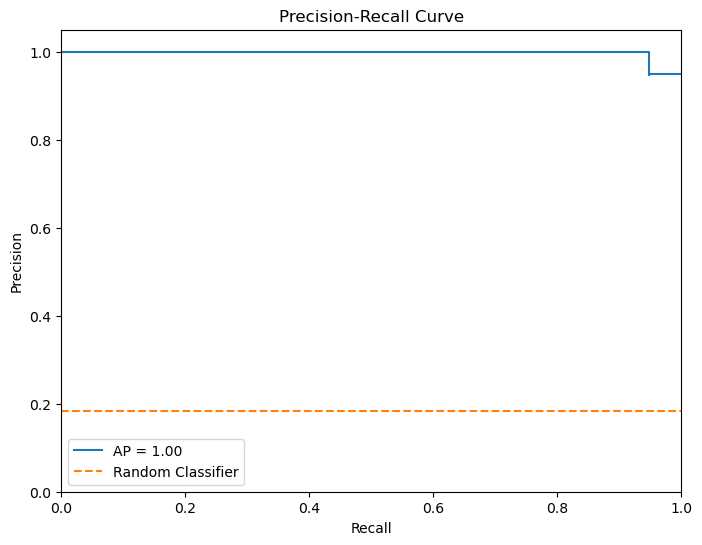

Average Precision Score: 1.00


In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# Predict probabilities
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_enc, y_pred_proba)

# Calculate average precision score
avg_precision = average_precision_score(y_test_enc, y_pred_proba)

# Create the plot
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label=f'AP = {avg_precision:.2f}')

# Add the random classifier line
no_skill = len(y_test[y_test == "WT"]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Classifier')

# Customize the plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Set axis limits
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

# Print the average precision score
print(f'Average Precision Score: {avg_precision:.2f}')